In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc


from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

sys.path.append('../dataset_construction')
sys.path.append('../../util')
from pano_utils import *
import panoseti_file_interfaces as pfi

In [2]:
data_dir = '/Users/nico/Downloads/panoseti_test_data/obs_data/data'
run_dir = 'obs_Lick.start_2023-08-01T05:14:21Z.runtype_sci-obs.pffd'


def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df

In [3]:
ori = pfi.ObservingRunInterface(data_dir, run_dir)

In [4]:
ori.obs_pff_files

{254: {'img': [{'fname': 'start_2023-08-01T05_15_07Z.dp_img16.bpp_2.module_254.seqno_0.pff',
    'seqno': 0,
    'nframes': 1574804,
    'first_unix_t': 1690866913.6438074,
    'last_unix_t': 1690867071.1241076},
   {'fname': 'start_2023-08-01T05_17_51Z.dp_img16.bpp_2.module_254.seqno_1.pff',
    'seqno': 1,
    'nframes': 1574804,
    'first_unix_t': 1690867071.1242075,
    'last_unix_t': 1690867228.6045074},
   {'fname': 'start_2023-08-01T05_20_28Z.dp_img16.bpp_2.module_254.seqno_2.pff',
    'seqno': 2,
    'nframes': 1574804,
    'first_unix_t': 1690867228.6046076,
    'last_unix_t': 1690867386.0849075},
   {'fname': 'start_2023-08-01T05_23_06Z.dp_img16.bpp_2.module_254.seqno_3.pff',
    'seqno': 3,
    'nframes': 1574804,
    'first_unix_t': 1690867386.0850074,
    'last_unix_t': 1690867543.5653074},
   {'fname': 'start_2023-08-01T05_25_43Z.dp_img16.bpp_2.module_254.seqno_4.pff',
    'seqno': 4,
    'nframes': 1574804,
    'first_unix_t': 1690867543.5654075,
    'last_unix_t': 1690

In [5]:
# plt.figure(figsize=(3,3))
# plot_img(median_img[400], cbar=True)
# plt.title('Median image');
# plt.show()

# plt.figure(figsize=(3,3))
# plot_img(median_img, cbar=True)
# plt.title('Median image');
# plt.show()

In [6]:
def plot_img(data, cbar=False, ax=None, vmin=-50, vmax=50, cmap='rocket'):
    div = 1 / np.sqrt(abs(data))
    div = np.nan_to_num(div, nan=1)
    
    if ax:
        im_orig = ax.imshow(
            data * div, vmin=vmin, vmax=vmax, cmap=cmap,
        )
    else:
        im_orig = plt.imshow(
            data *  div, vmin=vmin, vmax=vmax, cmap='rocket'#cmap='crest_r',
        )
    if cbar:
        cbar_orig = plt.colorbar(im_orig, label='Counts', fraction=0.046, location='right')
    plt.axis('off')

In [7]:
def plot_grid(imgs, title, cols=10, rows_per_plot=10, vmin=-100, vmax=100, cmap='rocket'):
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    title_added = False
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                plot_img(img, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
                if not title_added:
                    ax.set_title(title)
                    title_added = True
        plt.show()
        plt.close()

In [ ]:
np.random.seed(50)
module_id = 1
for k in [5]:
    spatial_medians, buffer, buffer_no_spatial_medians, supermedian, flat = ori.compute_module_supermedian_image(
        module_id, spatial_median_window_usec=k*10**6, max_samples_per_window=100
    )
    sm_idxs = np.linspace(0, len(spatial_medians) - 1, 50).astype(int)
    bf_idxs = np.linspace(0, len(buffer) - 1, 50).astype(int)
    bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 50).astype(int)
    flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)

    
    plot_grid(spatial_medians[sm_idxs, :, :], f'(spatial medians) window_length = {k} s', vmin=10, vmax=15)
    # plot_grid(buffer[bf_idxs, :, :], f'(original) window_length = {k} s', vmin=10, vmax=15)
    plot_grid(buffer_no_spatial_medians[bfnsm_idxs, :, :], f'orig - (spatial median): window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')
    plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_26305/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


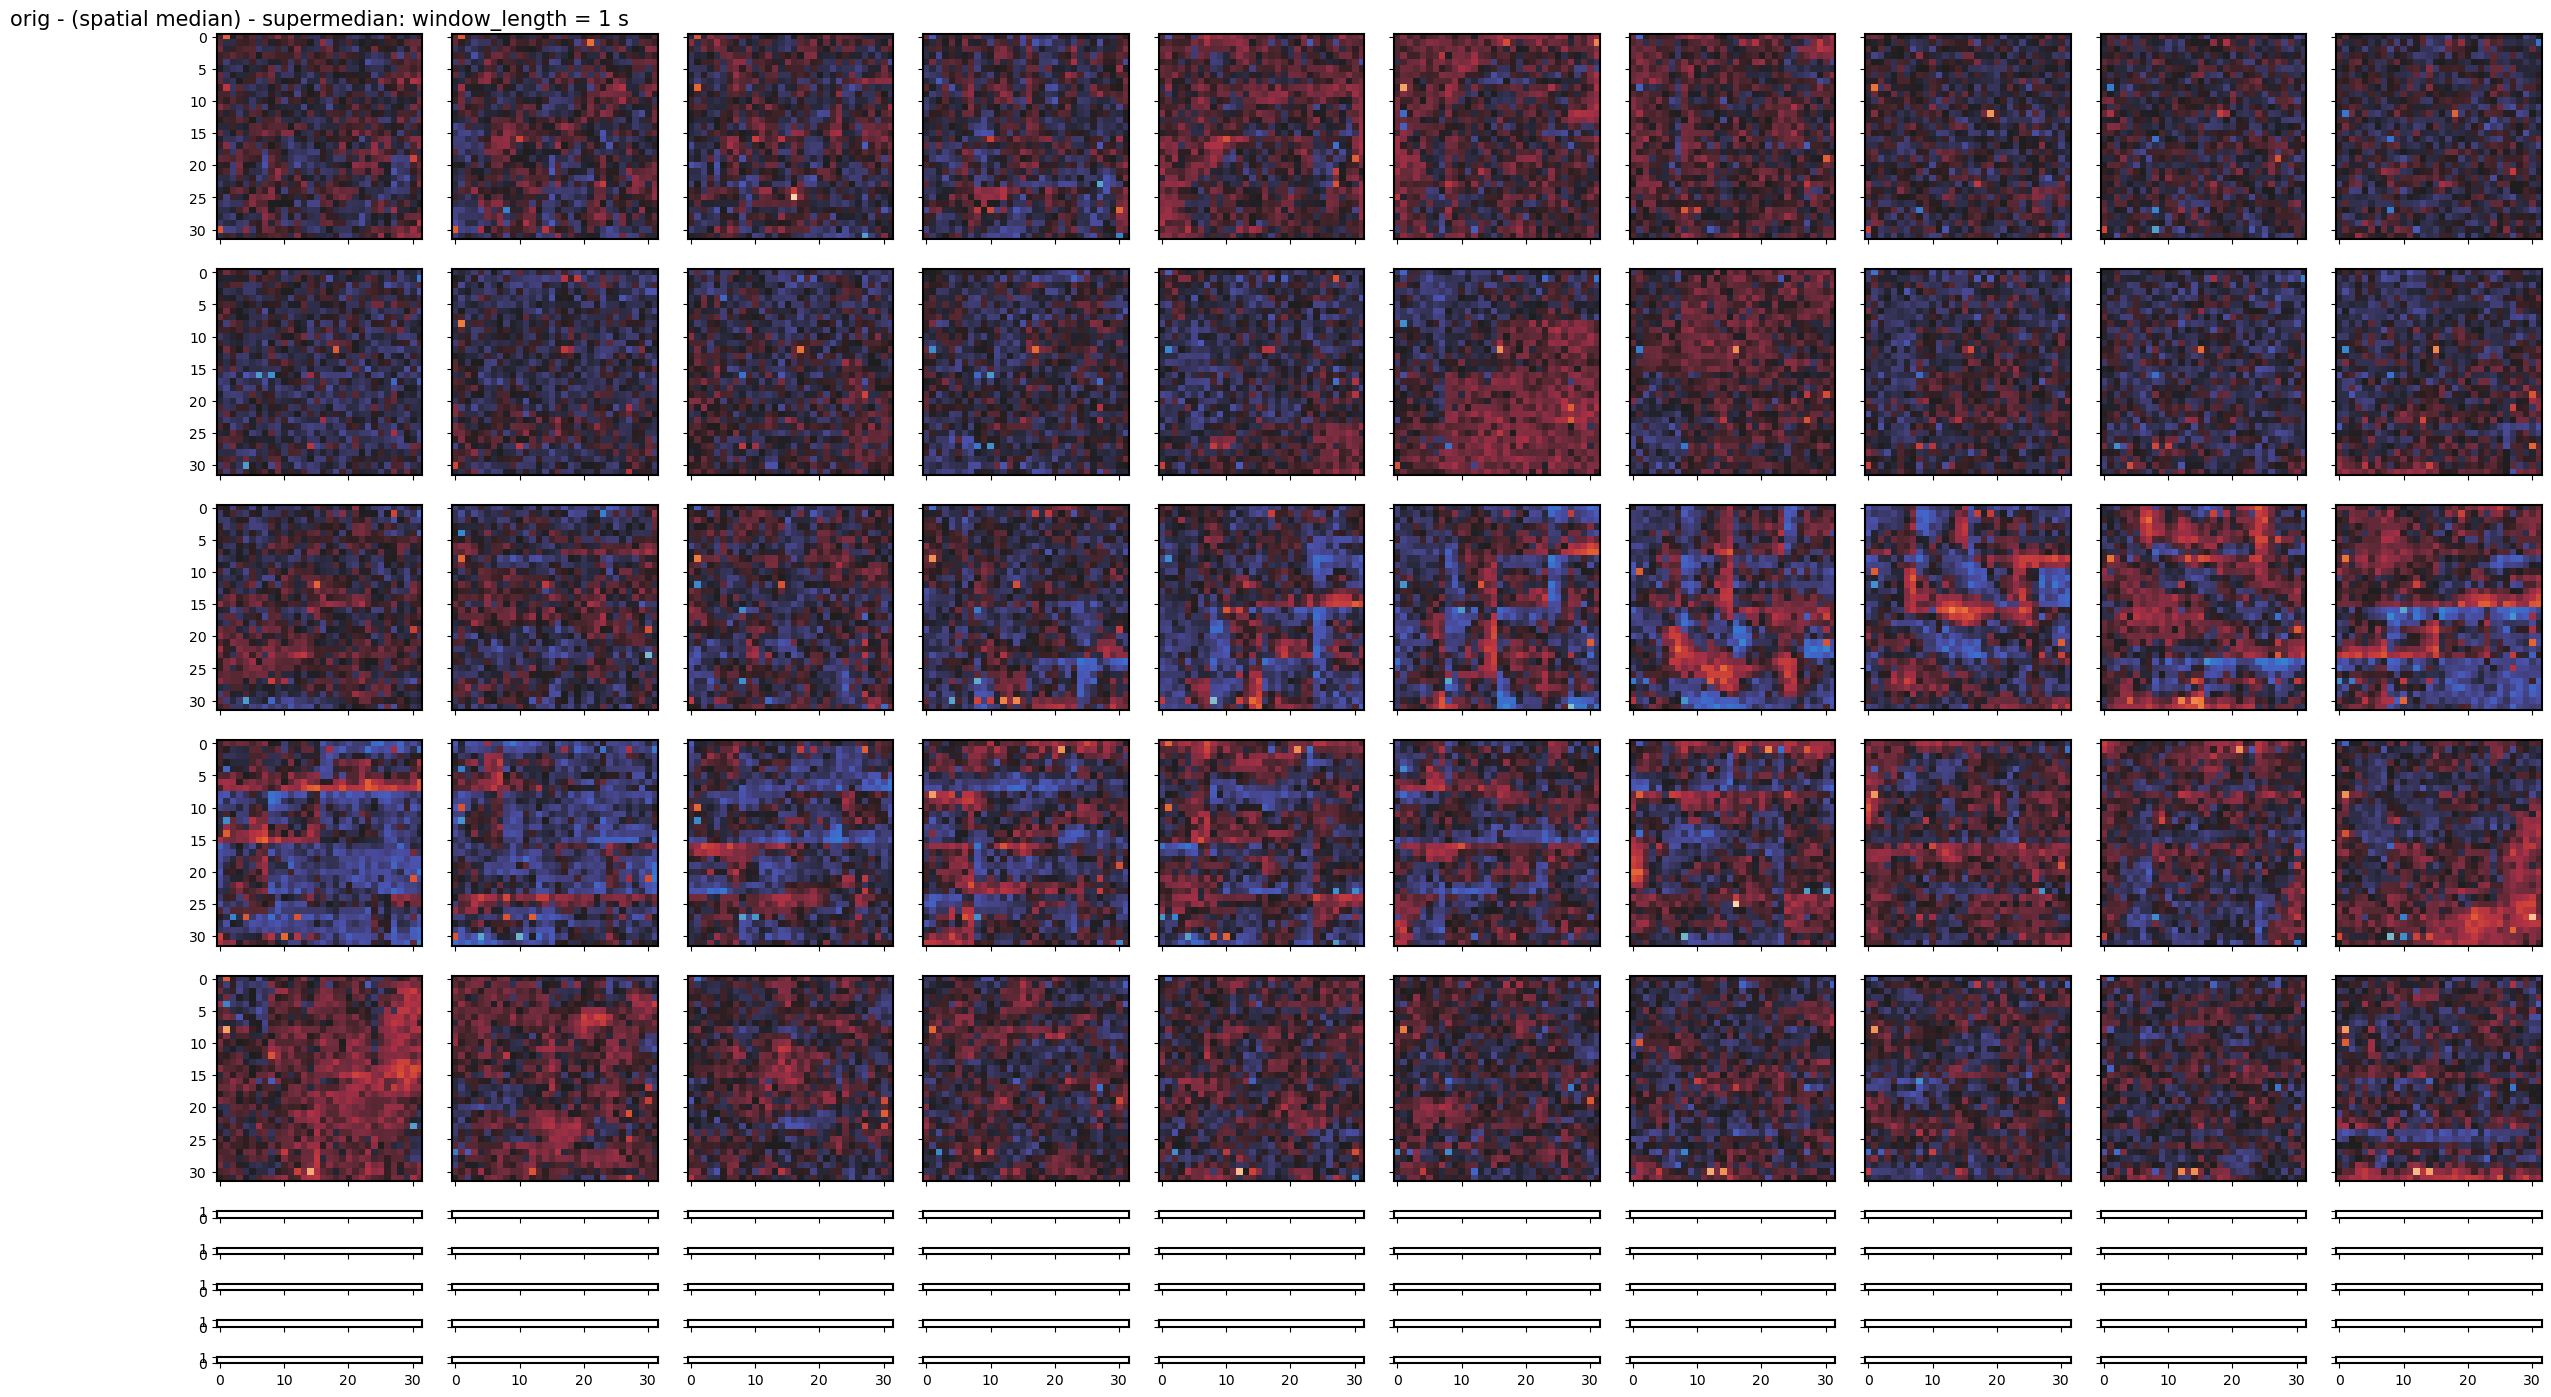

In [45]:
# nstack = 1
# flat_stacked = np.sum(
#     (buffer - supermedian * 2).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:])),
#     axis=0
# )
flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')

In [19]:
(nstack * ori.intgrn_usec / 1e6) * 60000

6.0

In [ ]:
flat_stacked.shape 

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_26305/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


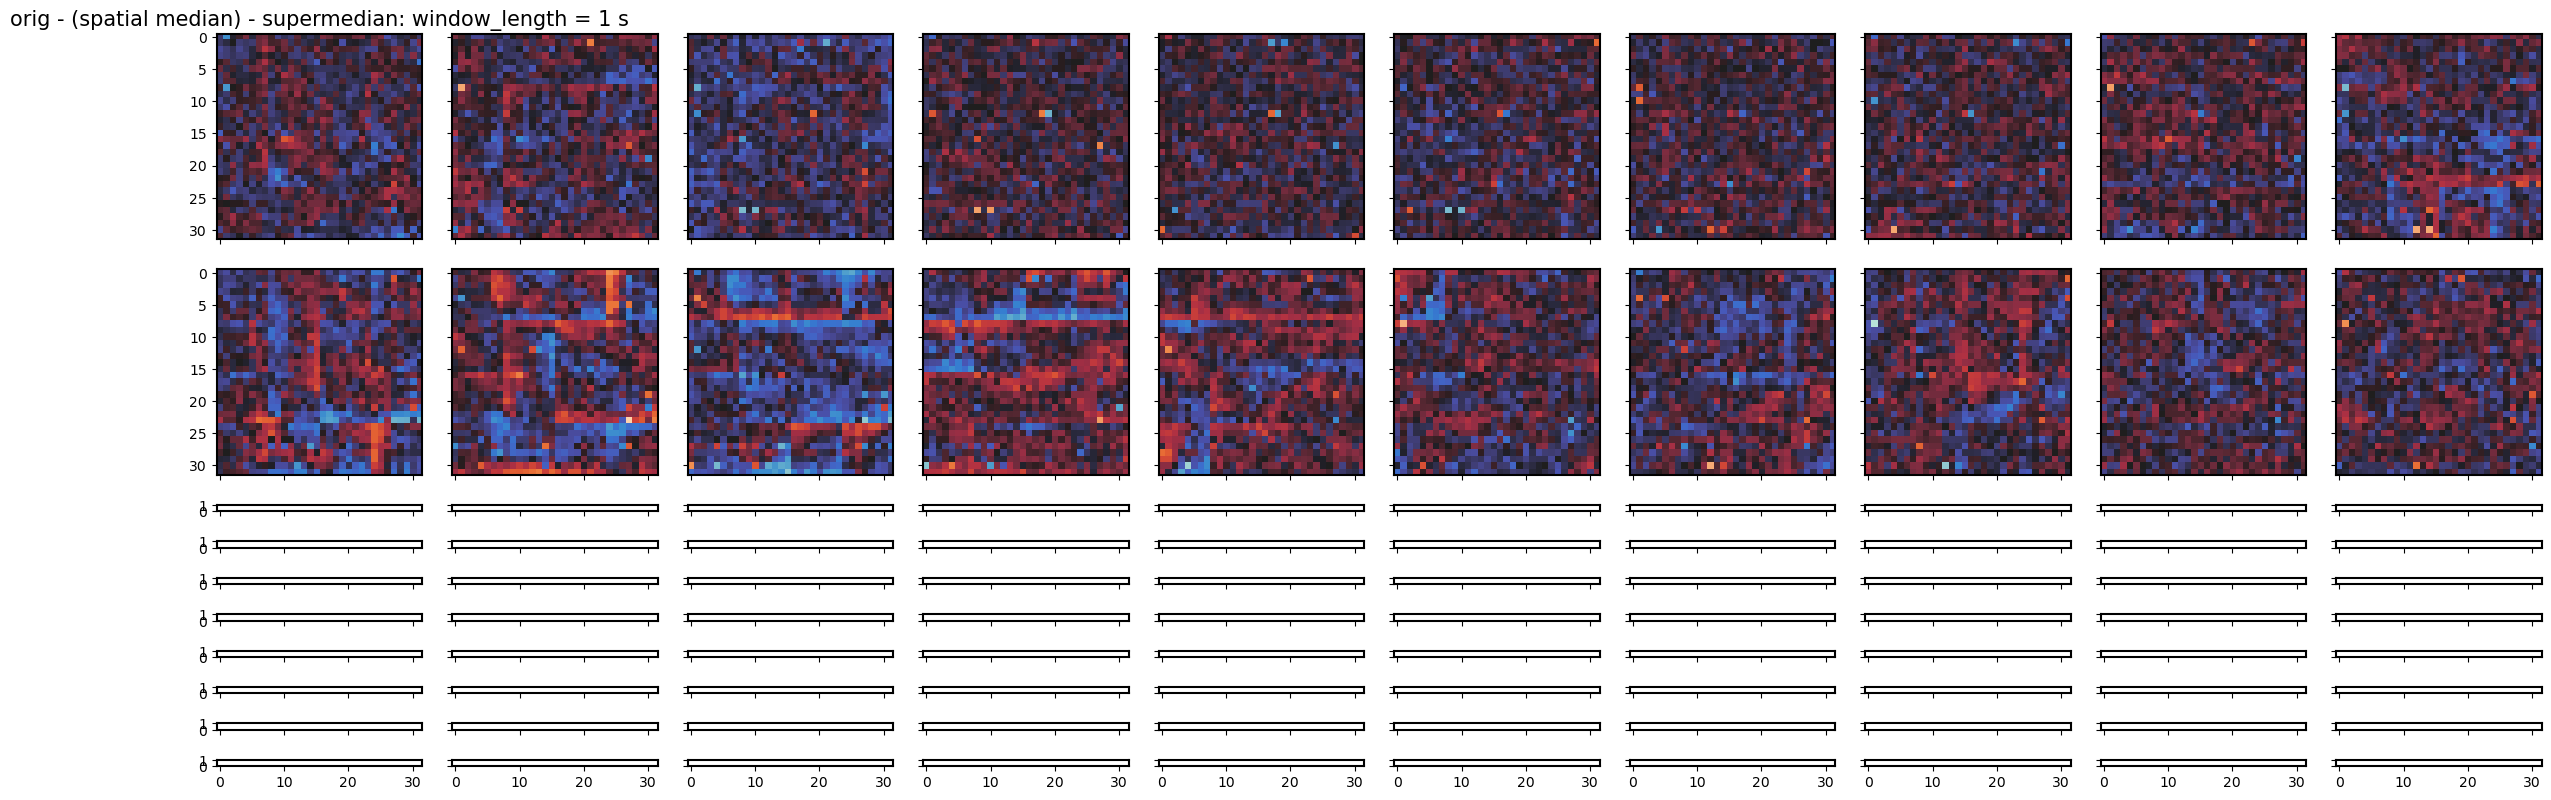

In [26]:
nstack = 1
flat_stacked = (buffer).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::6000], axis=0)
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 50)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_26305/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


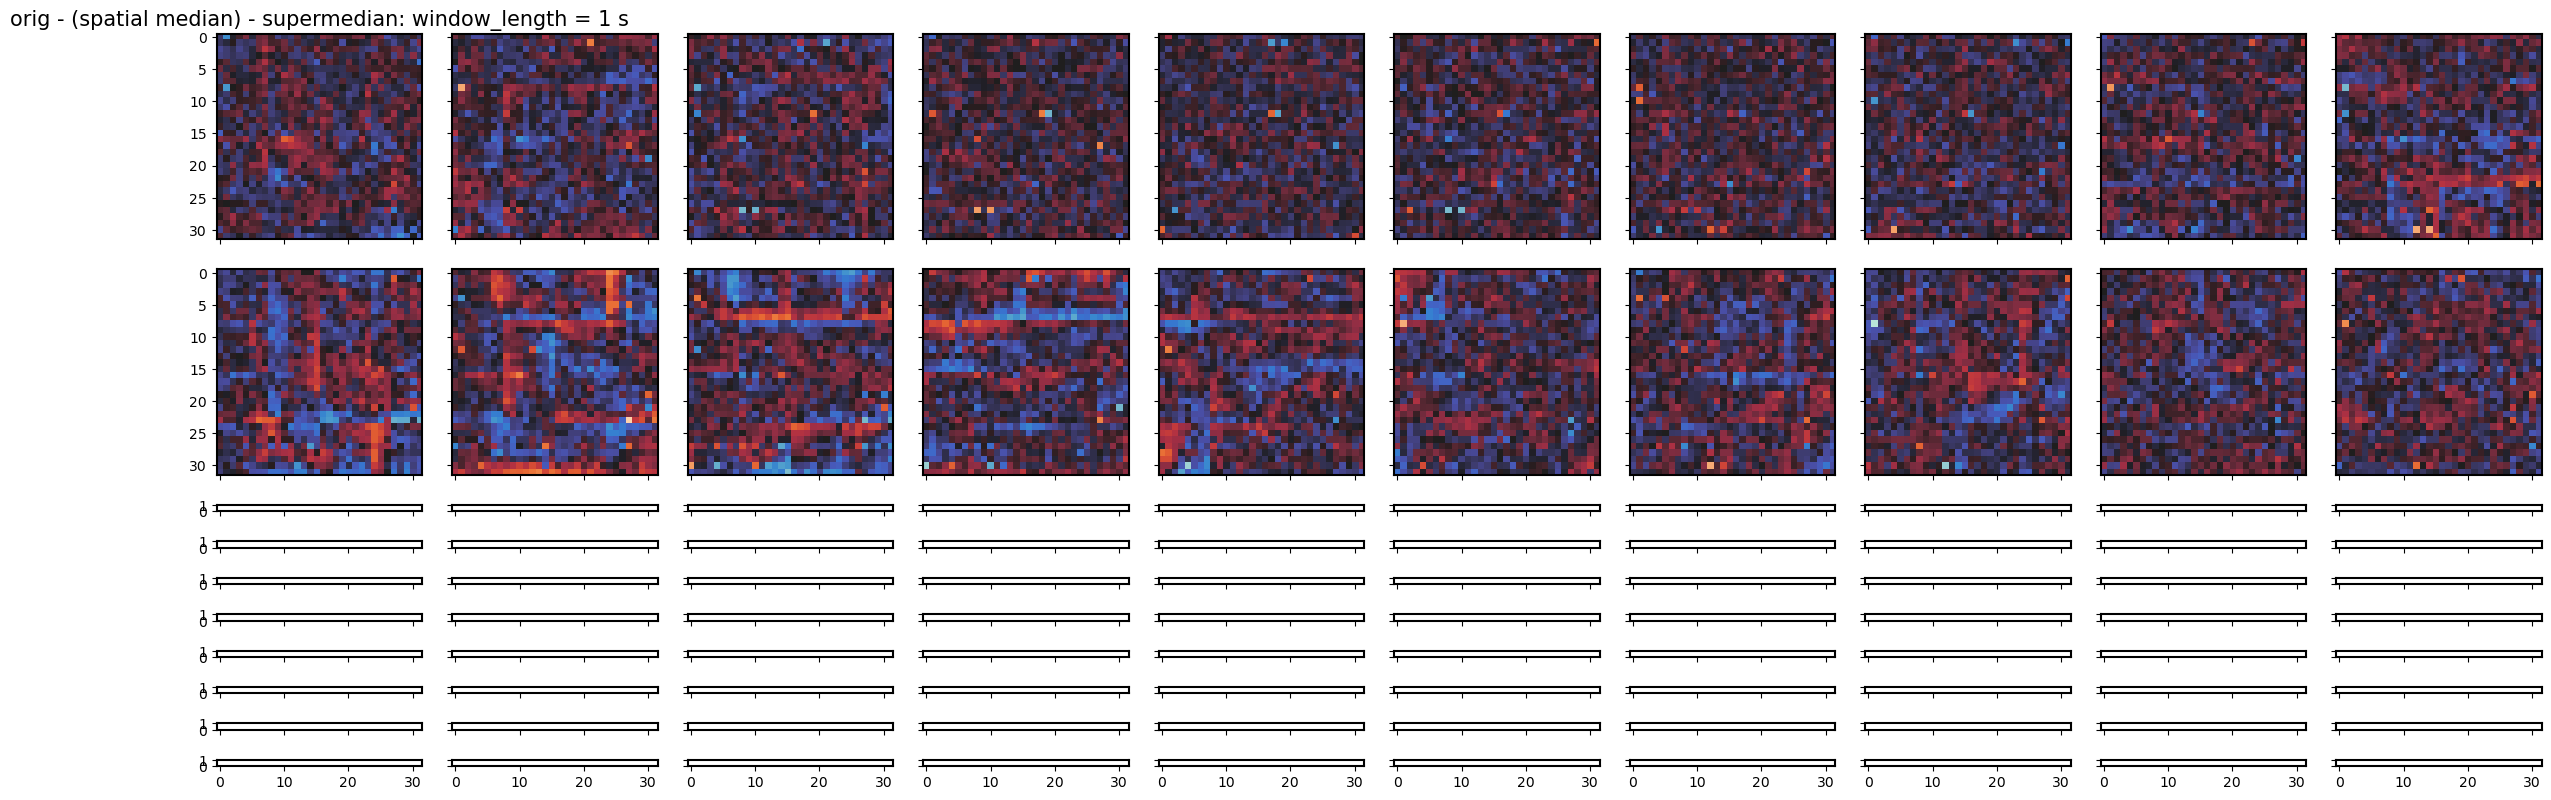

In [25]:
nstack = 1
flat_stacked = (buffer_no_spatial_medians).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::6000], axis=0)
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 50)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_26305/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


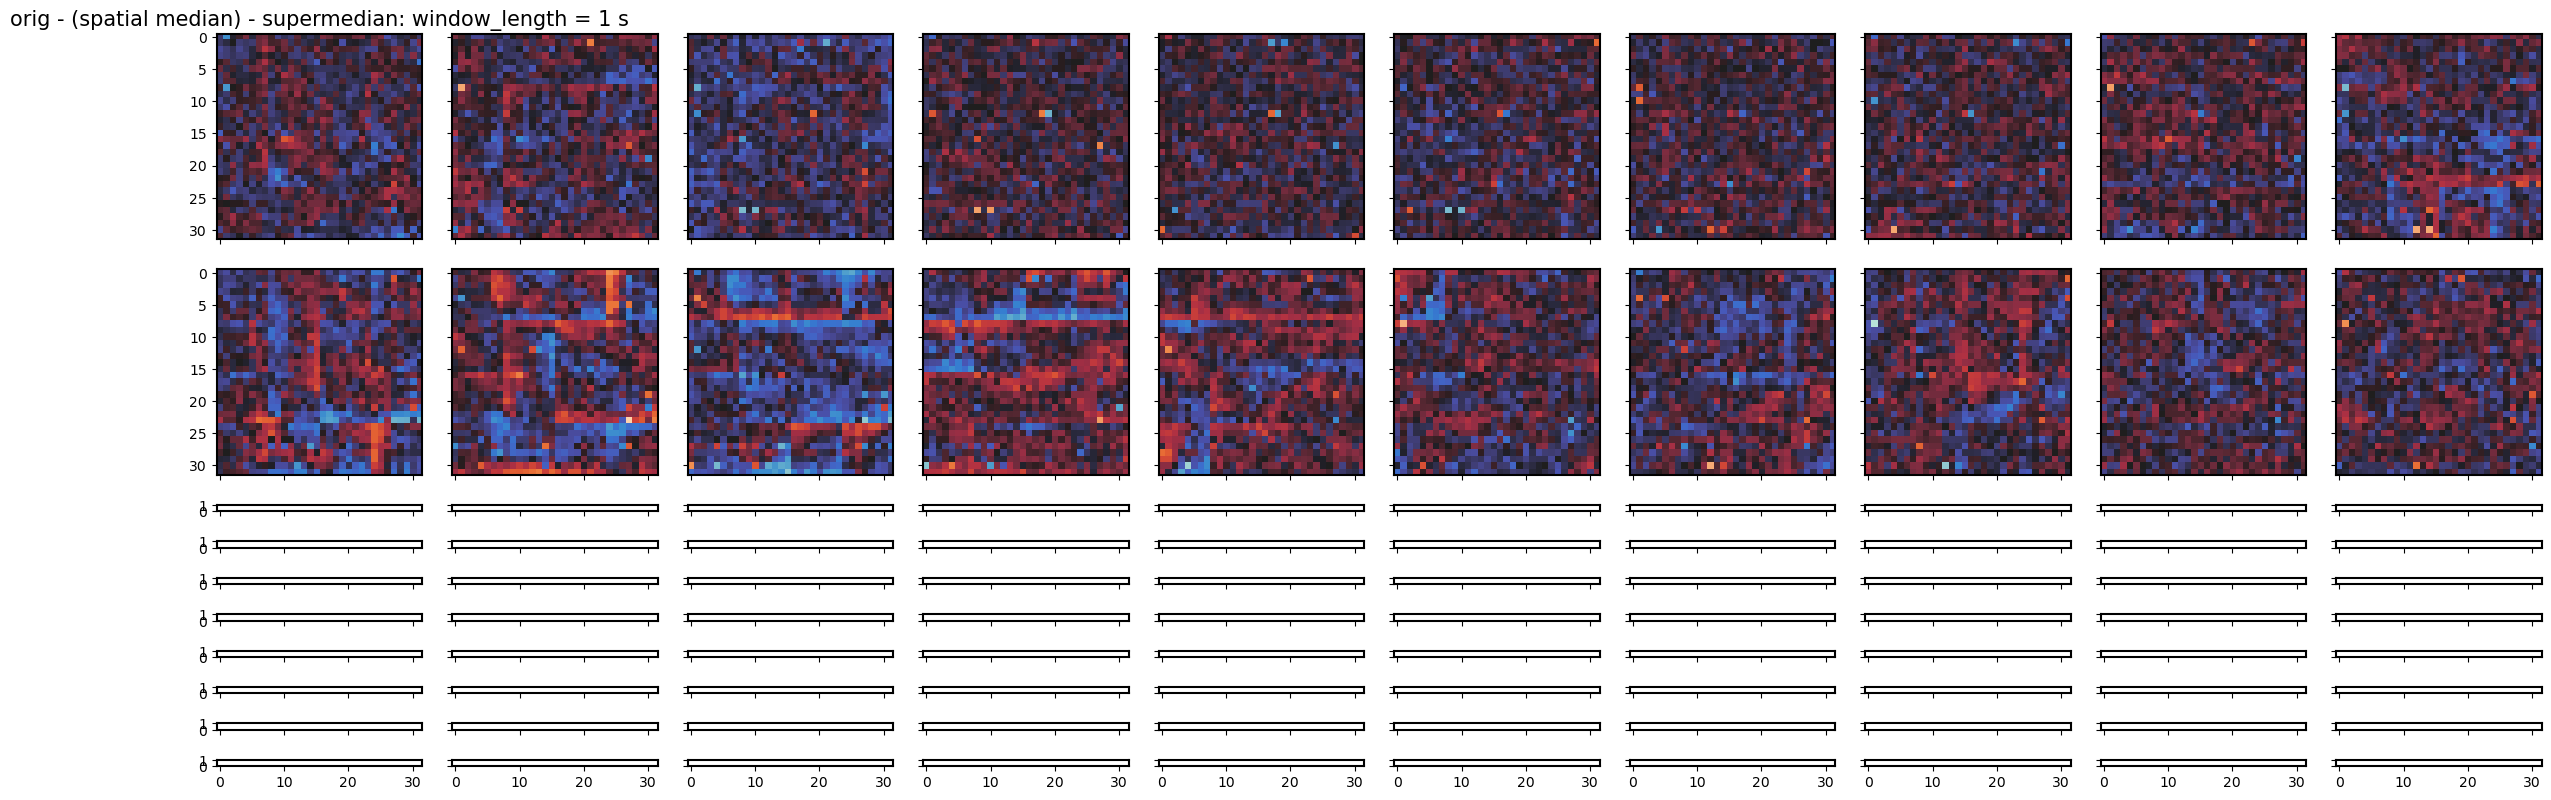

In [24]:
nstack = 1
flat_stacked = (buffer - supermedian).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::6000], axis=0)
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 50)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_26305/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


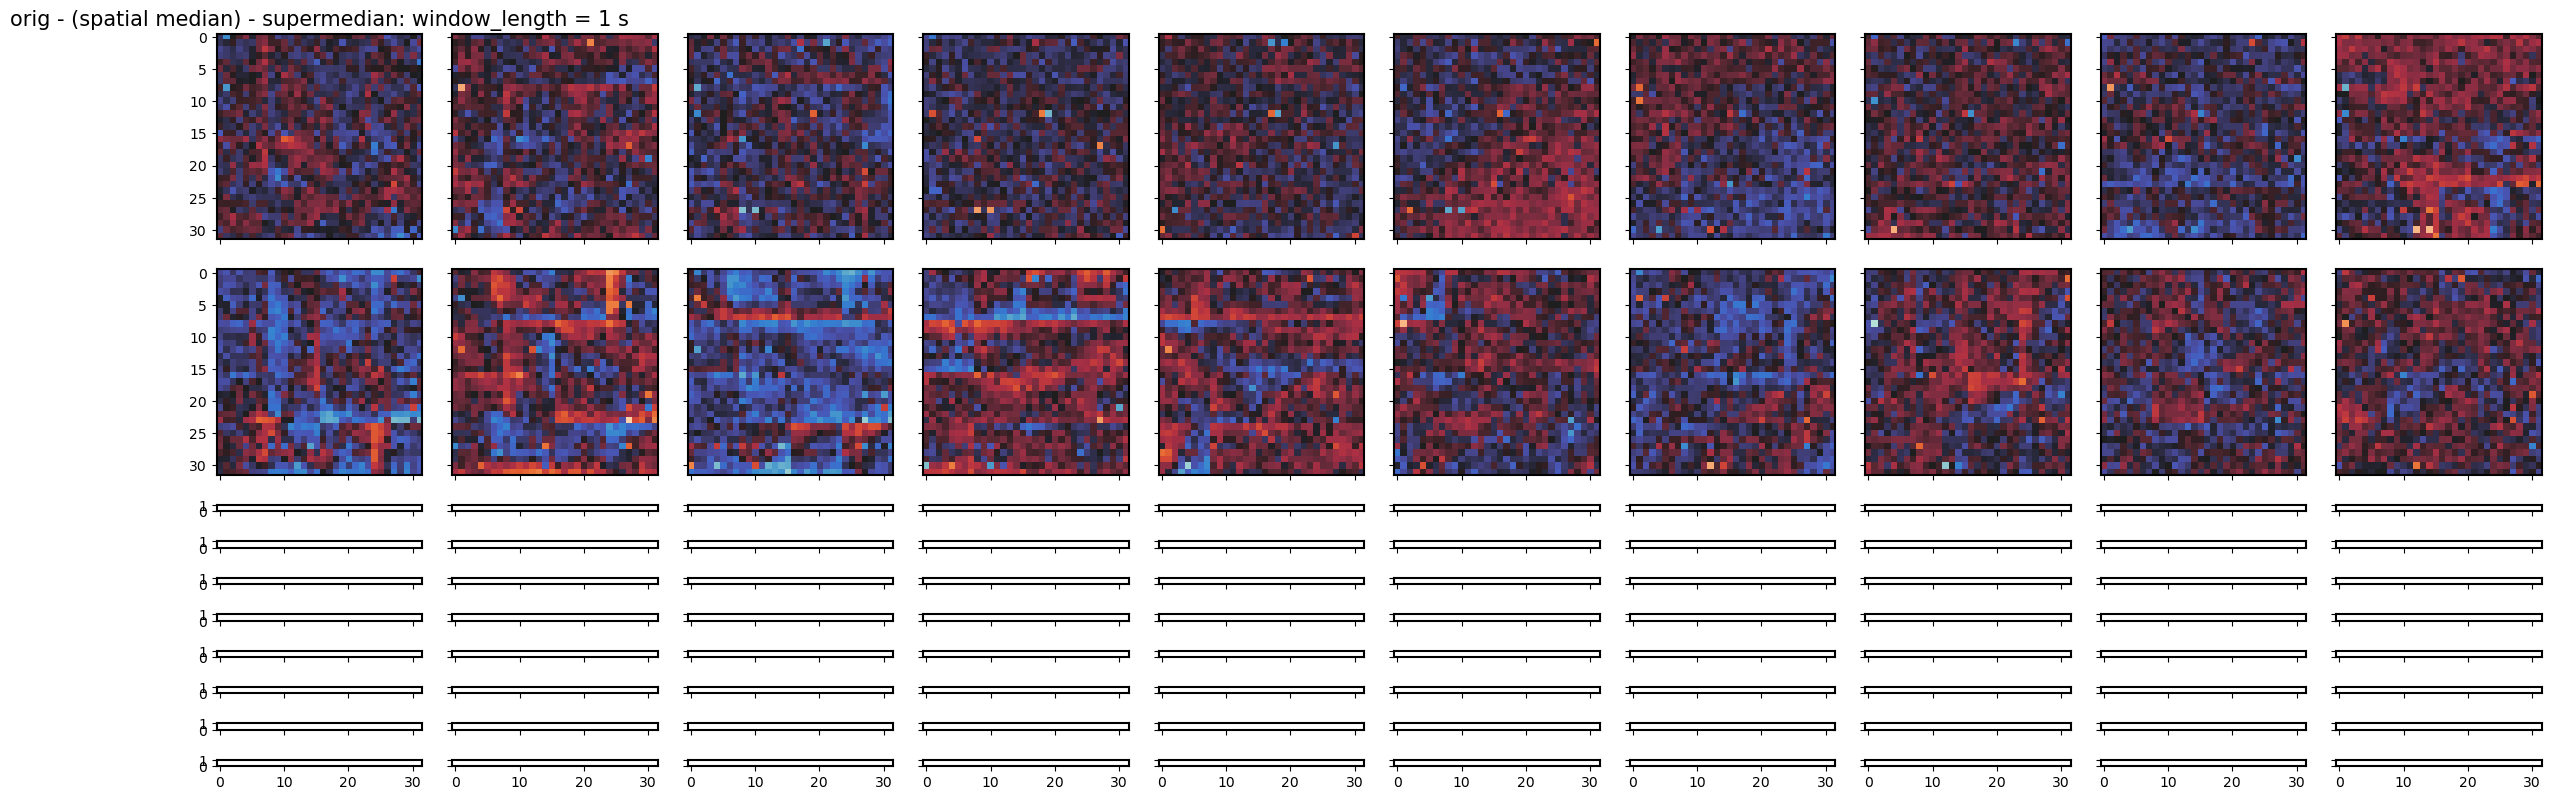

In [27]:
nstack = 1
flat_stacked = (flat).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::6000], axis=0)
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 50)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

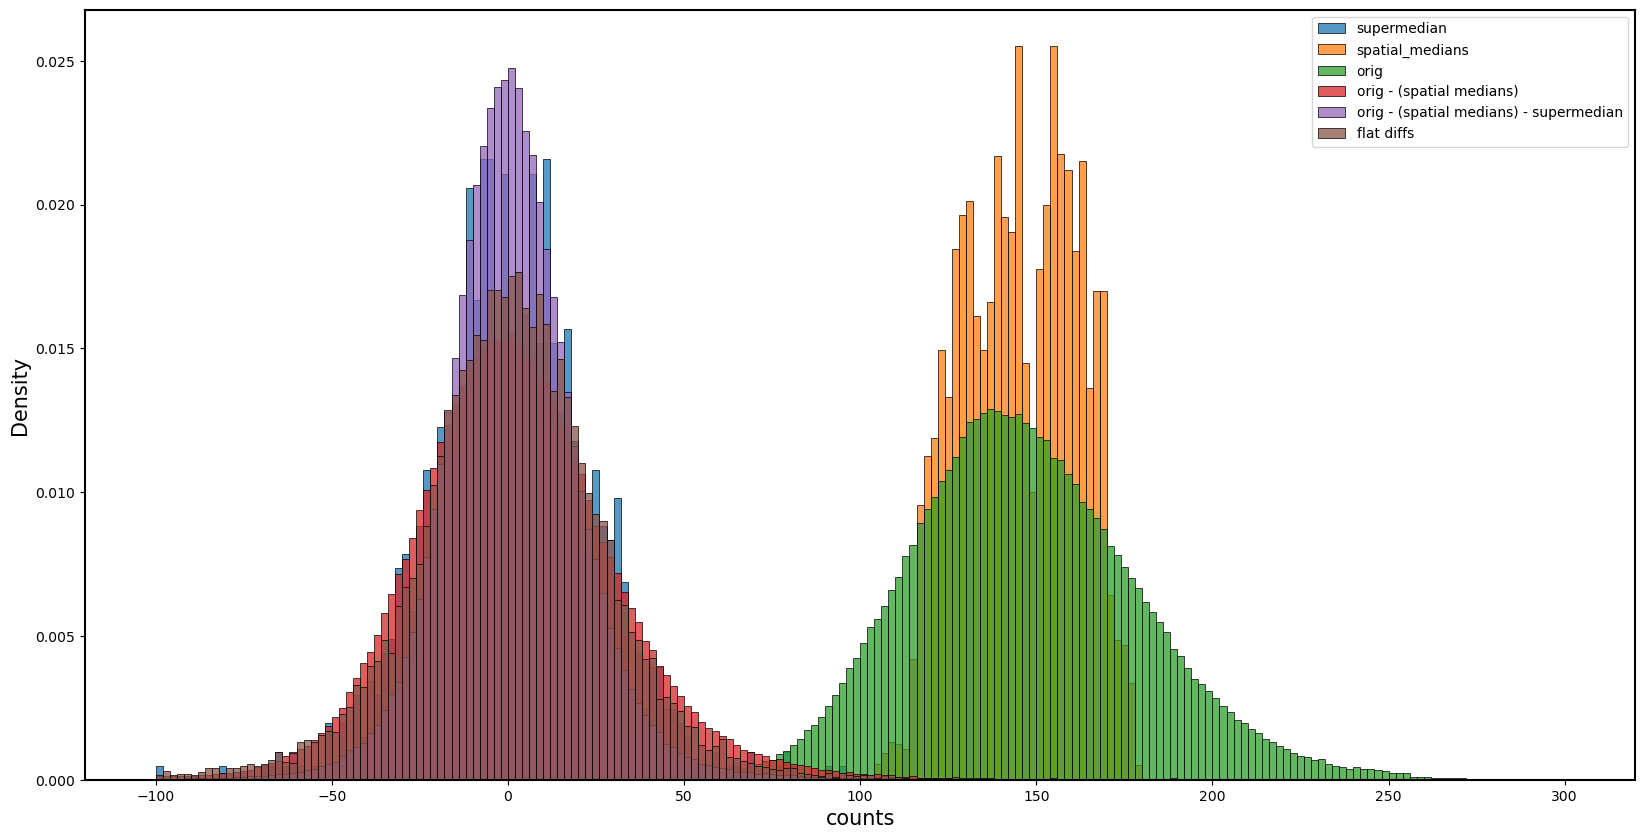

In [44]:
plt.figure(figsize=(20,10))
binrange = [-100, 300]
bins = 200

sm_idxs = np.linspace(0, len(spatial_medians) - 1, 500).astype(int)
bf_idxs = np.linspace(0, len(buffer) - 1, 500).astype(int)
bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 500).astype(int)
flat_idxs = np.linspace(0, len(flat) - 1, 500).astype(int)

sns.histplot(supermedian.ravel(), stat='density', label='supermedian', binrange=binrange, bins=bins)
sns.histplot(
    spatial_medians[sm_idxs, :, :].ravel(),
    stat='density',
    label='spatial_medians',
    binrange=binrange,
    bins=bins)
sns.histplot(
    buffer[bf_idxs, :, :].ravel(),
    stat='density',
    label='orig',
    binrange=binrange,
    bins=bins
)
sns.histplot(
    buffer_no_spatial_medians[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians)',
    binrange=binrange, bins=bins
)
sns.histplot(
    flat[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians) - supermedian',
    binrange=binrange,
    bins=bins
)

sns.histplot(
    flat_diffs[flat_diff_idxs, :, :].ravel(),
    stat='density',
    label='flat diffs',
    binrange=binrange,
    bins=bins
)

# plt.xlim(-100, 100)
plt.xlabel('counts')
plt.legend()